In [1]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

def calculate_metrics(true_values, pred_values):
    mse = round(mean_squared_error(true_values, pred_values),3)
    mae = round(mean_absolute_error(true_values, pred_values),3)
    r_score = round(r2_score(true_values, pred_values),3)

    return {"mse": mse,
            "mae": mae,
            "r_score": r_score,}

In [3]:
import pandas as pd
import os
import sys
sys.path.insert(0, r'C:\work\DrugDiscovery\main_git\XAI_Chem')

from ml_part.random_forest.data_prep.preparation import DataPreparation
from train import RFTrain

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

CSV_PATH = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\remained_features.csv'
smiles_filepath = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\smiles_to_index.pkl'

dataPreparation = DataPreparation(CSV_PATH)

X, y = dataPreparation.prepare_data_for_RF(is_pKa=True,
                                           use_mandatory_features=True,
                                           is_remove_outliers=True)

rf_train = RFTrain(X=X, 
                   y=y,
                   smiles_filepath=smiles_filepath)


PNSA5 [37, 38]
PBF [40, 71, 127]
FPSA3 [40]
mol_volume [127]
f_atom_fraction [124]
linear_distance [88, 89, 123, 126, 127, 140]
logP [82, 83]
Remains rows:165, amount of features: 53


In [4]:
best_hyperparams = rf_train.find_best_params_with_hyperopt()

model = rf_train.train(max_depth=best_hyperparams['max_depth'], 
                       max_features=best_hyperparams['max_features'], 
                       min_samples_leaf=best_hyperparams['min_samples_leaf'], 
                       min_samples_split=best_hyperparams['min_samples_split'], 
                       n_estimators=best_hyperparams['n_estimators'])


100%|██████████| 1000/1000 [30:29<00:00,  1.83s/trial, best loss: 6.641472241542451]
Найкращі гіперпараметри: {'max_depth': 3, 'max_features': 16, 'min_samples_leaf': 0, 'min_samples_split': 14, 'n_estimators': 3}


InvalidParameterError: The 'min_samples_leaf' parameter of RandomForestRegressor must be an int in the range [1, inf) or a float in the range (0.0, 1.0). Got 0 instead.

In [9]:
model = rf_train.train()

Mean Squared Error: 0.479715146885816


In [10]:
y_test = rf_train.y_test
X_test = rf_train.X_test
y_pred = model.predict(X_test)

calculate_metrics(y_test, y_pred)

{'mse': 0.48, 'mae': 0.554, 'r_score': 0.923}

In [11]:
y_test = rf_train.y_test
X_test = rf_train.X_test
y_pred = model.predict(X_test)

calculate_metrics(y_test, y_pred)

{'mse': 0.48, 'mae': 0.554, 'r_score': 0.923}

In [12]:
import joblib

save_path_for_rf = r'C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part\random_forest\models\pKa_rf.joblib'

joblib.dump(model, save_path_for_rf)

['C:\\work\\DrugDiscovery\\main_git\\XAI_Chem\\ml_part\\random_forest\\models\\pKa_rf.joblib']

<BarContainer object of 51 artists>

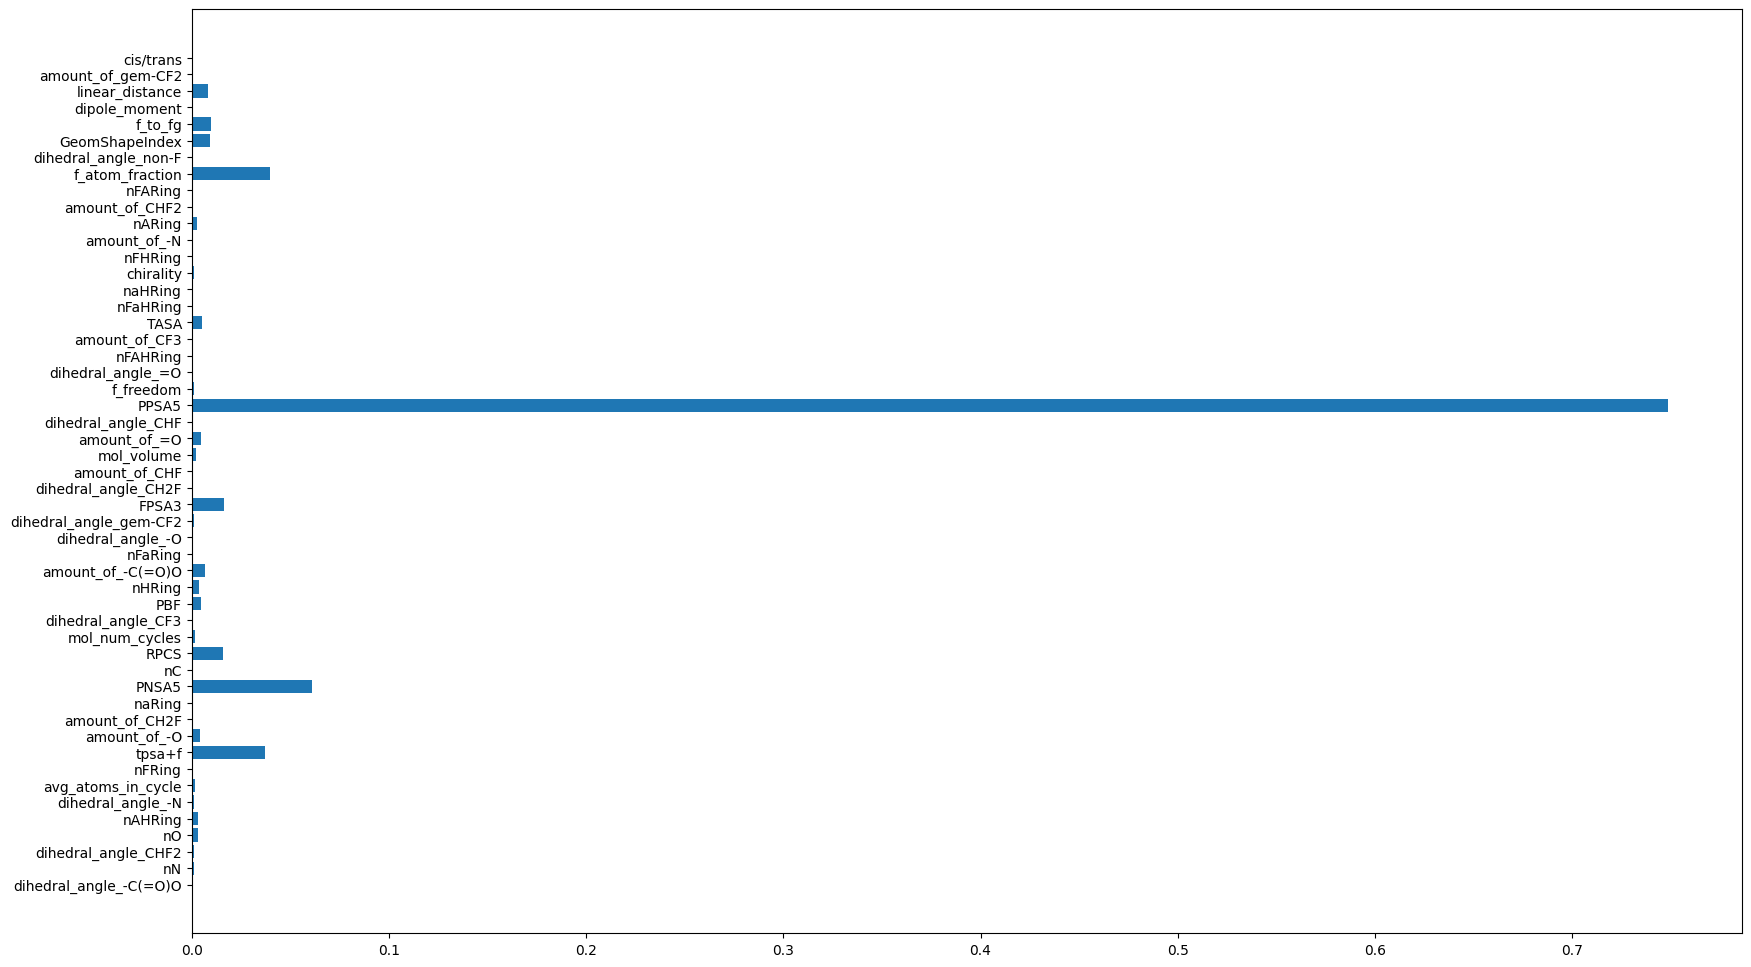

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,12))
plt.barh(X.columns, model.feature_importances_)

<BarContainer object of 51 artists>

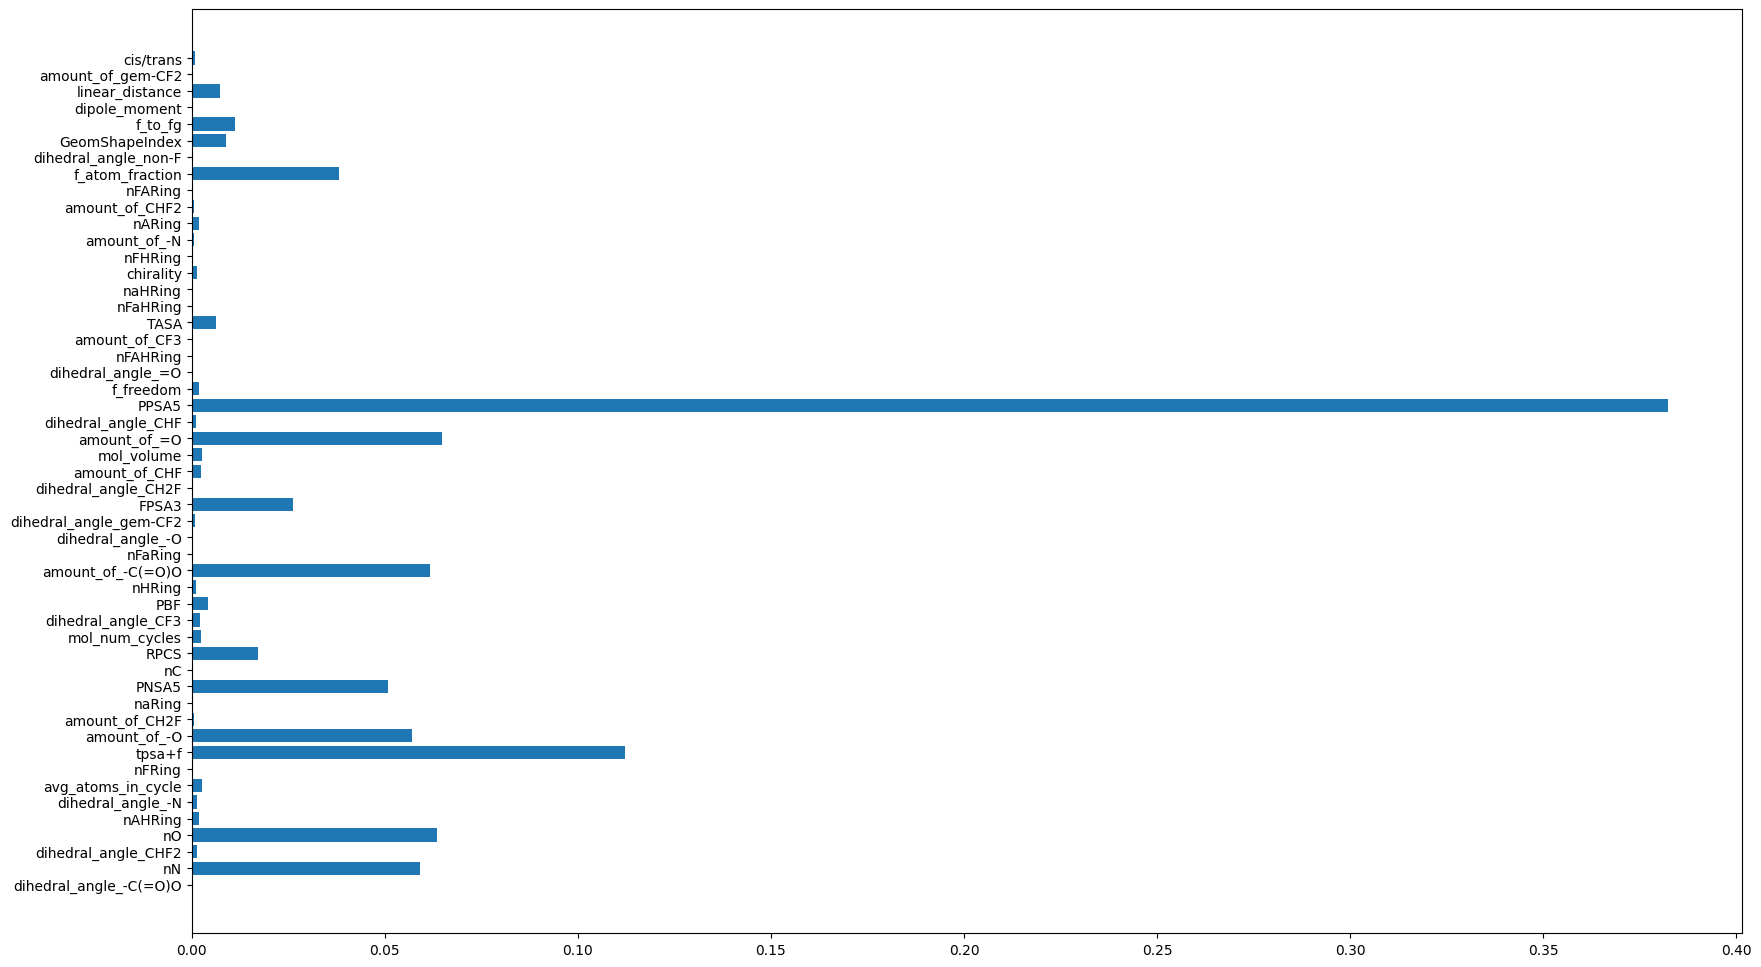

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,12))
plt.barh(X.columns, model.feature_importances_)

Text(0.5, 0, 'Random Forest Feature Importance')

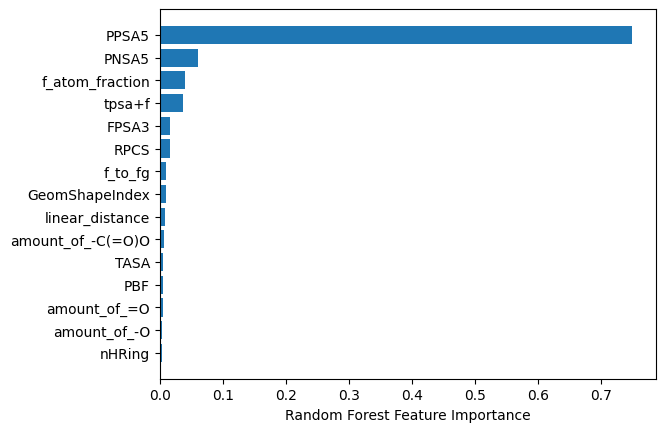

In [15]:
sorted_idx = model.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx][::-1][:15][::-1], model.feature_importances_[sorted_idx][::-1][:15][::-1])
plt.xlabel("Random Forest Feature Importance")

Text(0.5, 0, 'Random Forest Feature Importance')

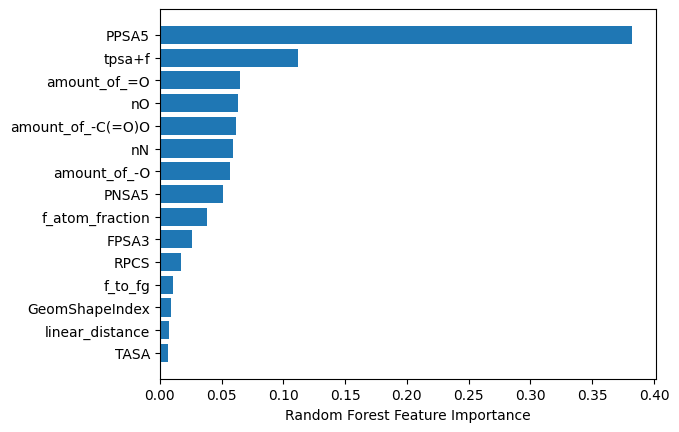

In [6]:
sorted_idx = model.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx][::-1][:15][::-1], model.feature_importances_[sorted_idx][::-1][:15][::-1])
plt.xlabel("Random Forest Feature Importance")

feature permutation

Text(0.5, 0, 'Permutation Importance')

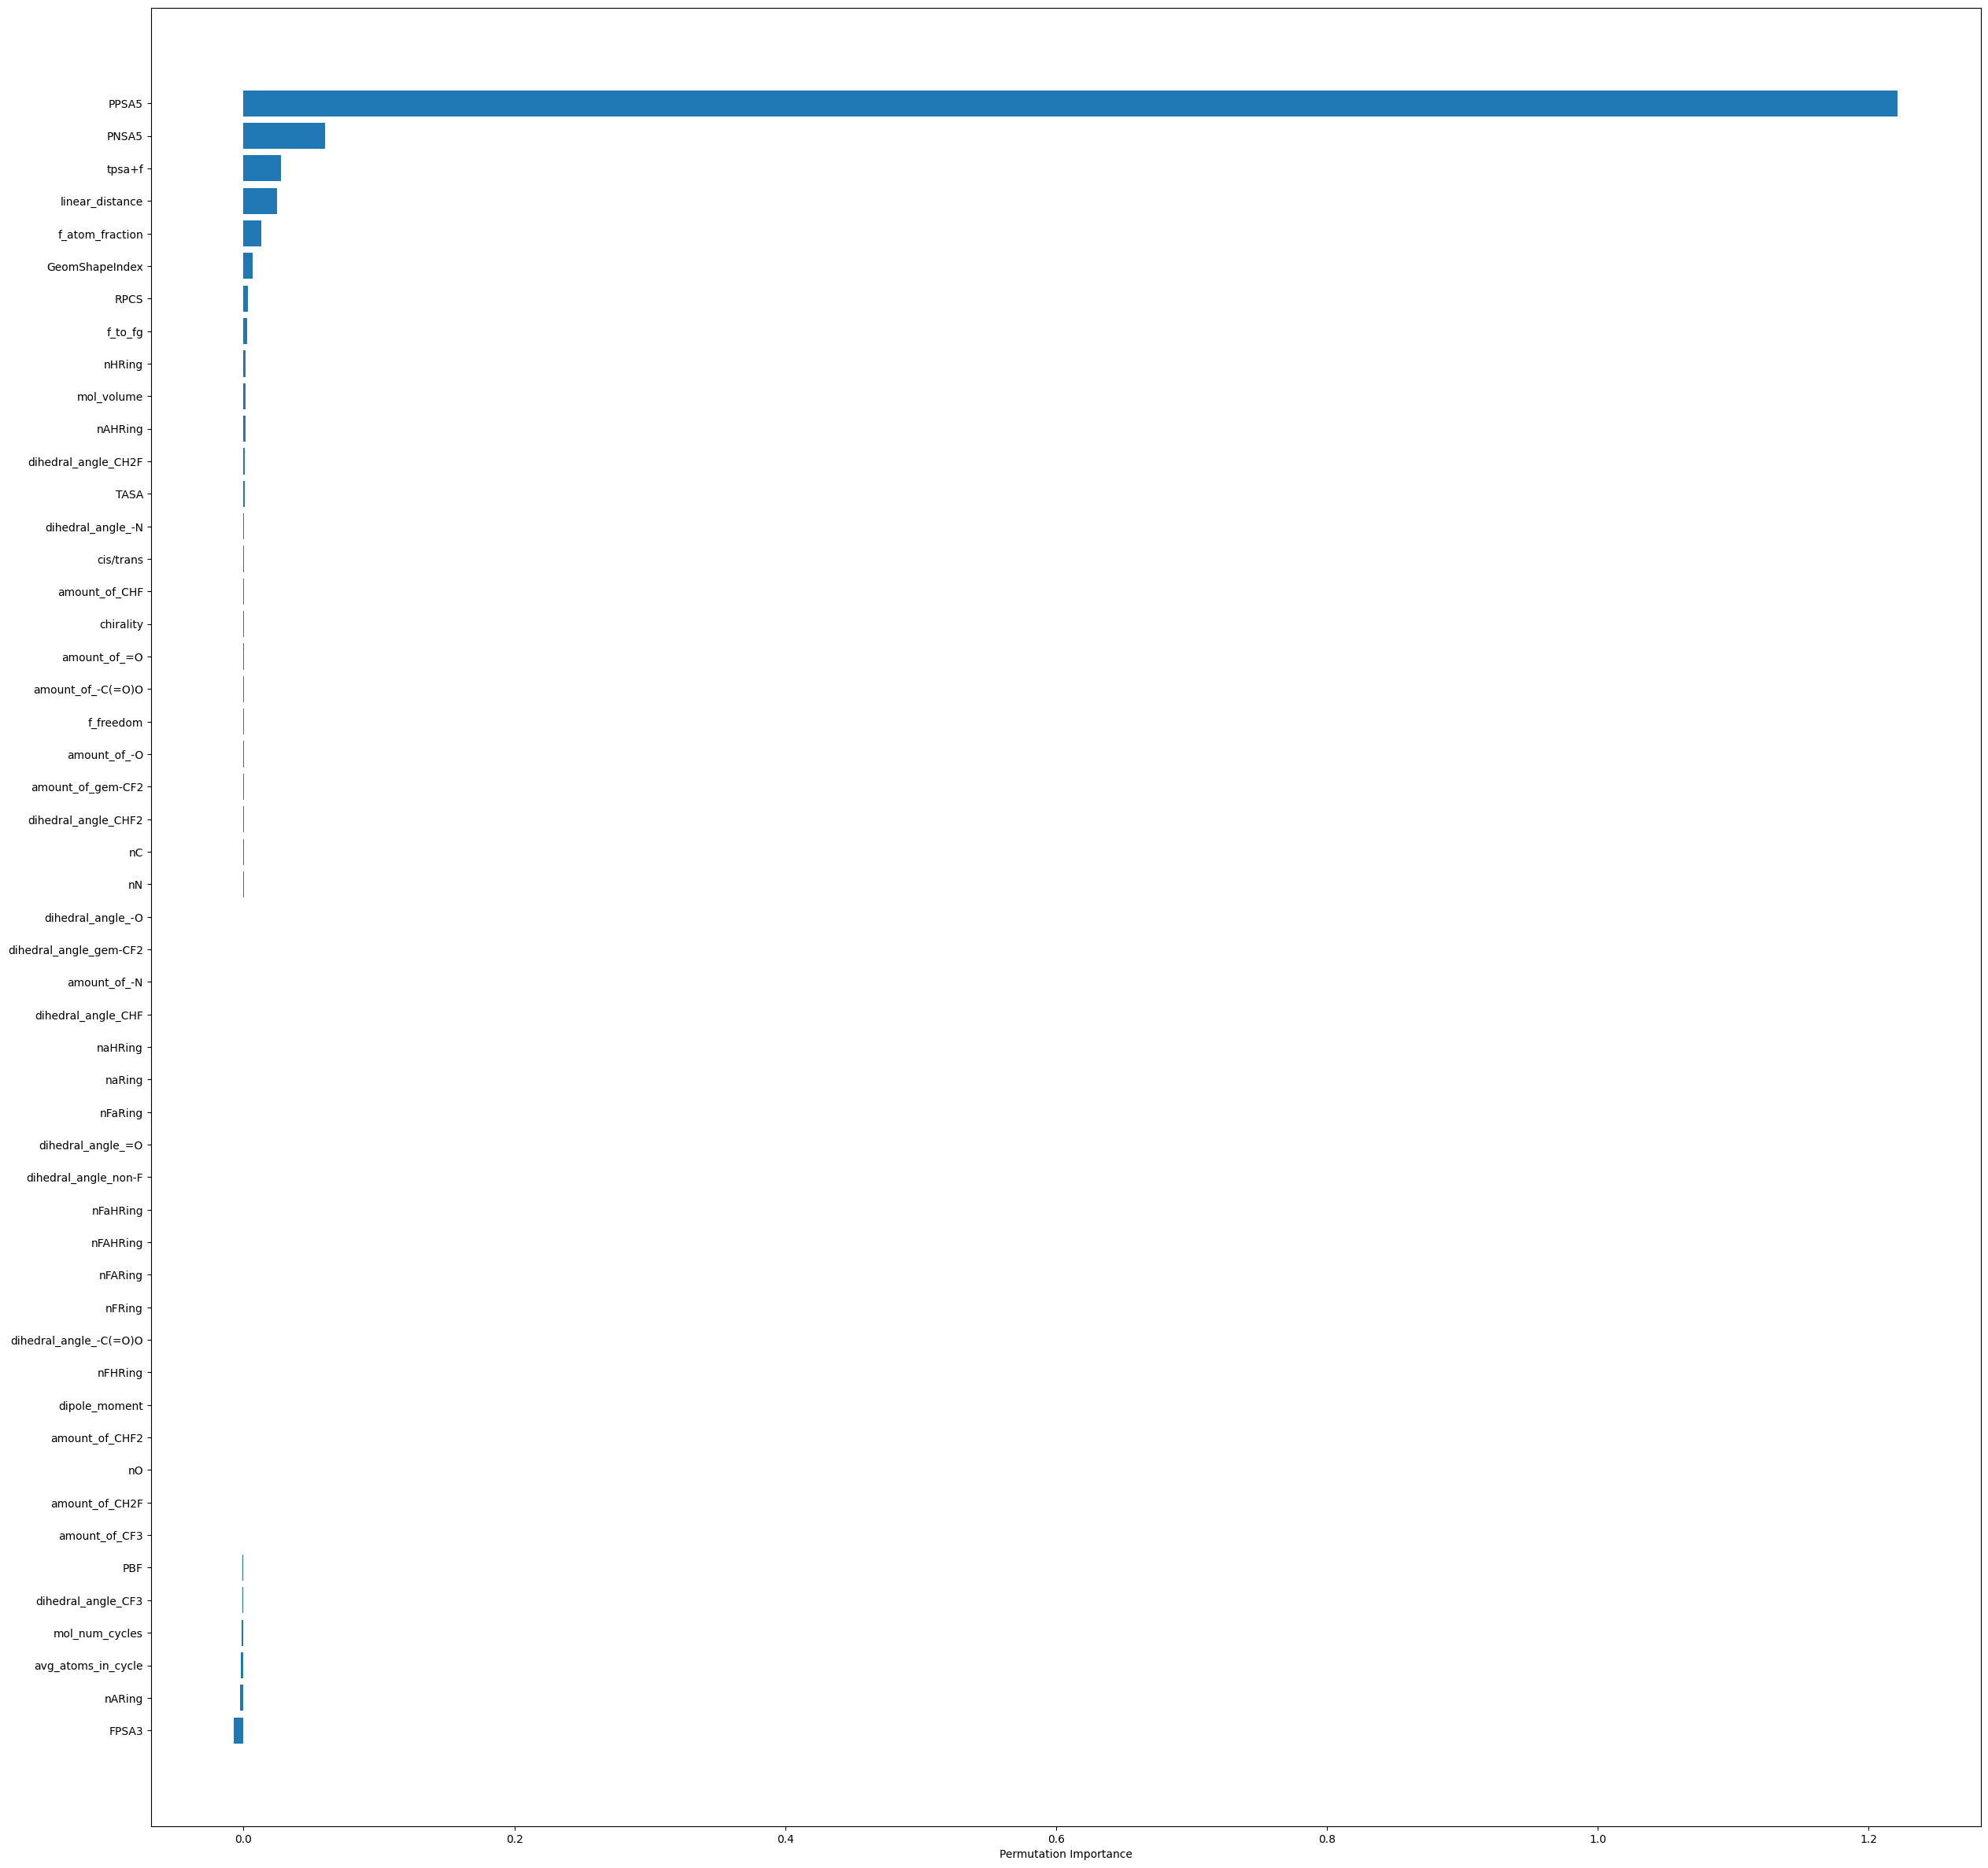

In [16]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(model, X_test, y_test)

sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(30,30))
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

Text(0.5, 0, 'Permutation Importance')

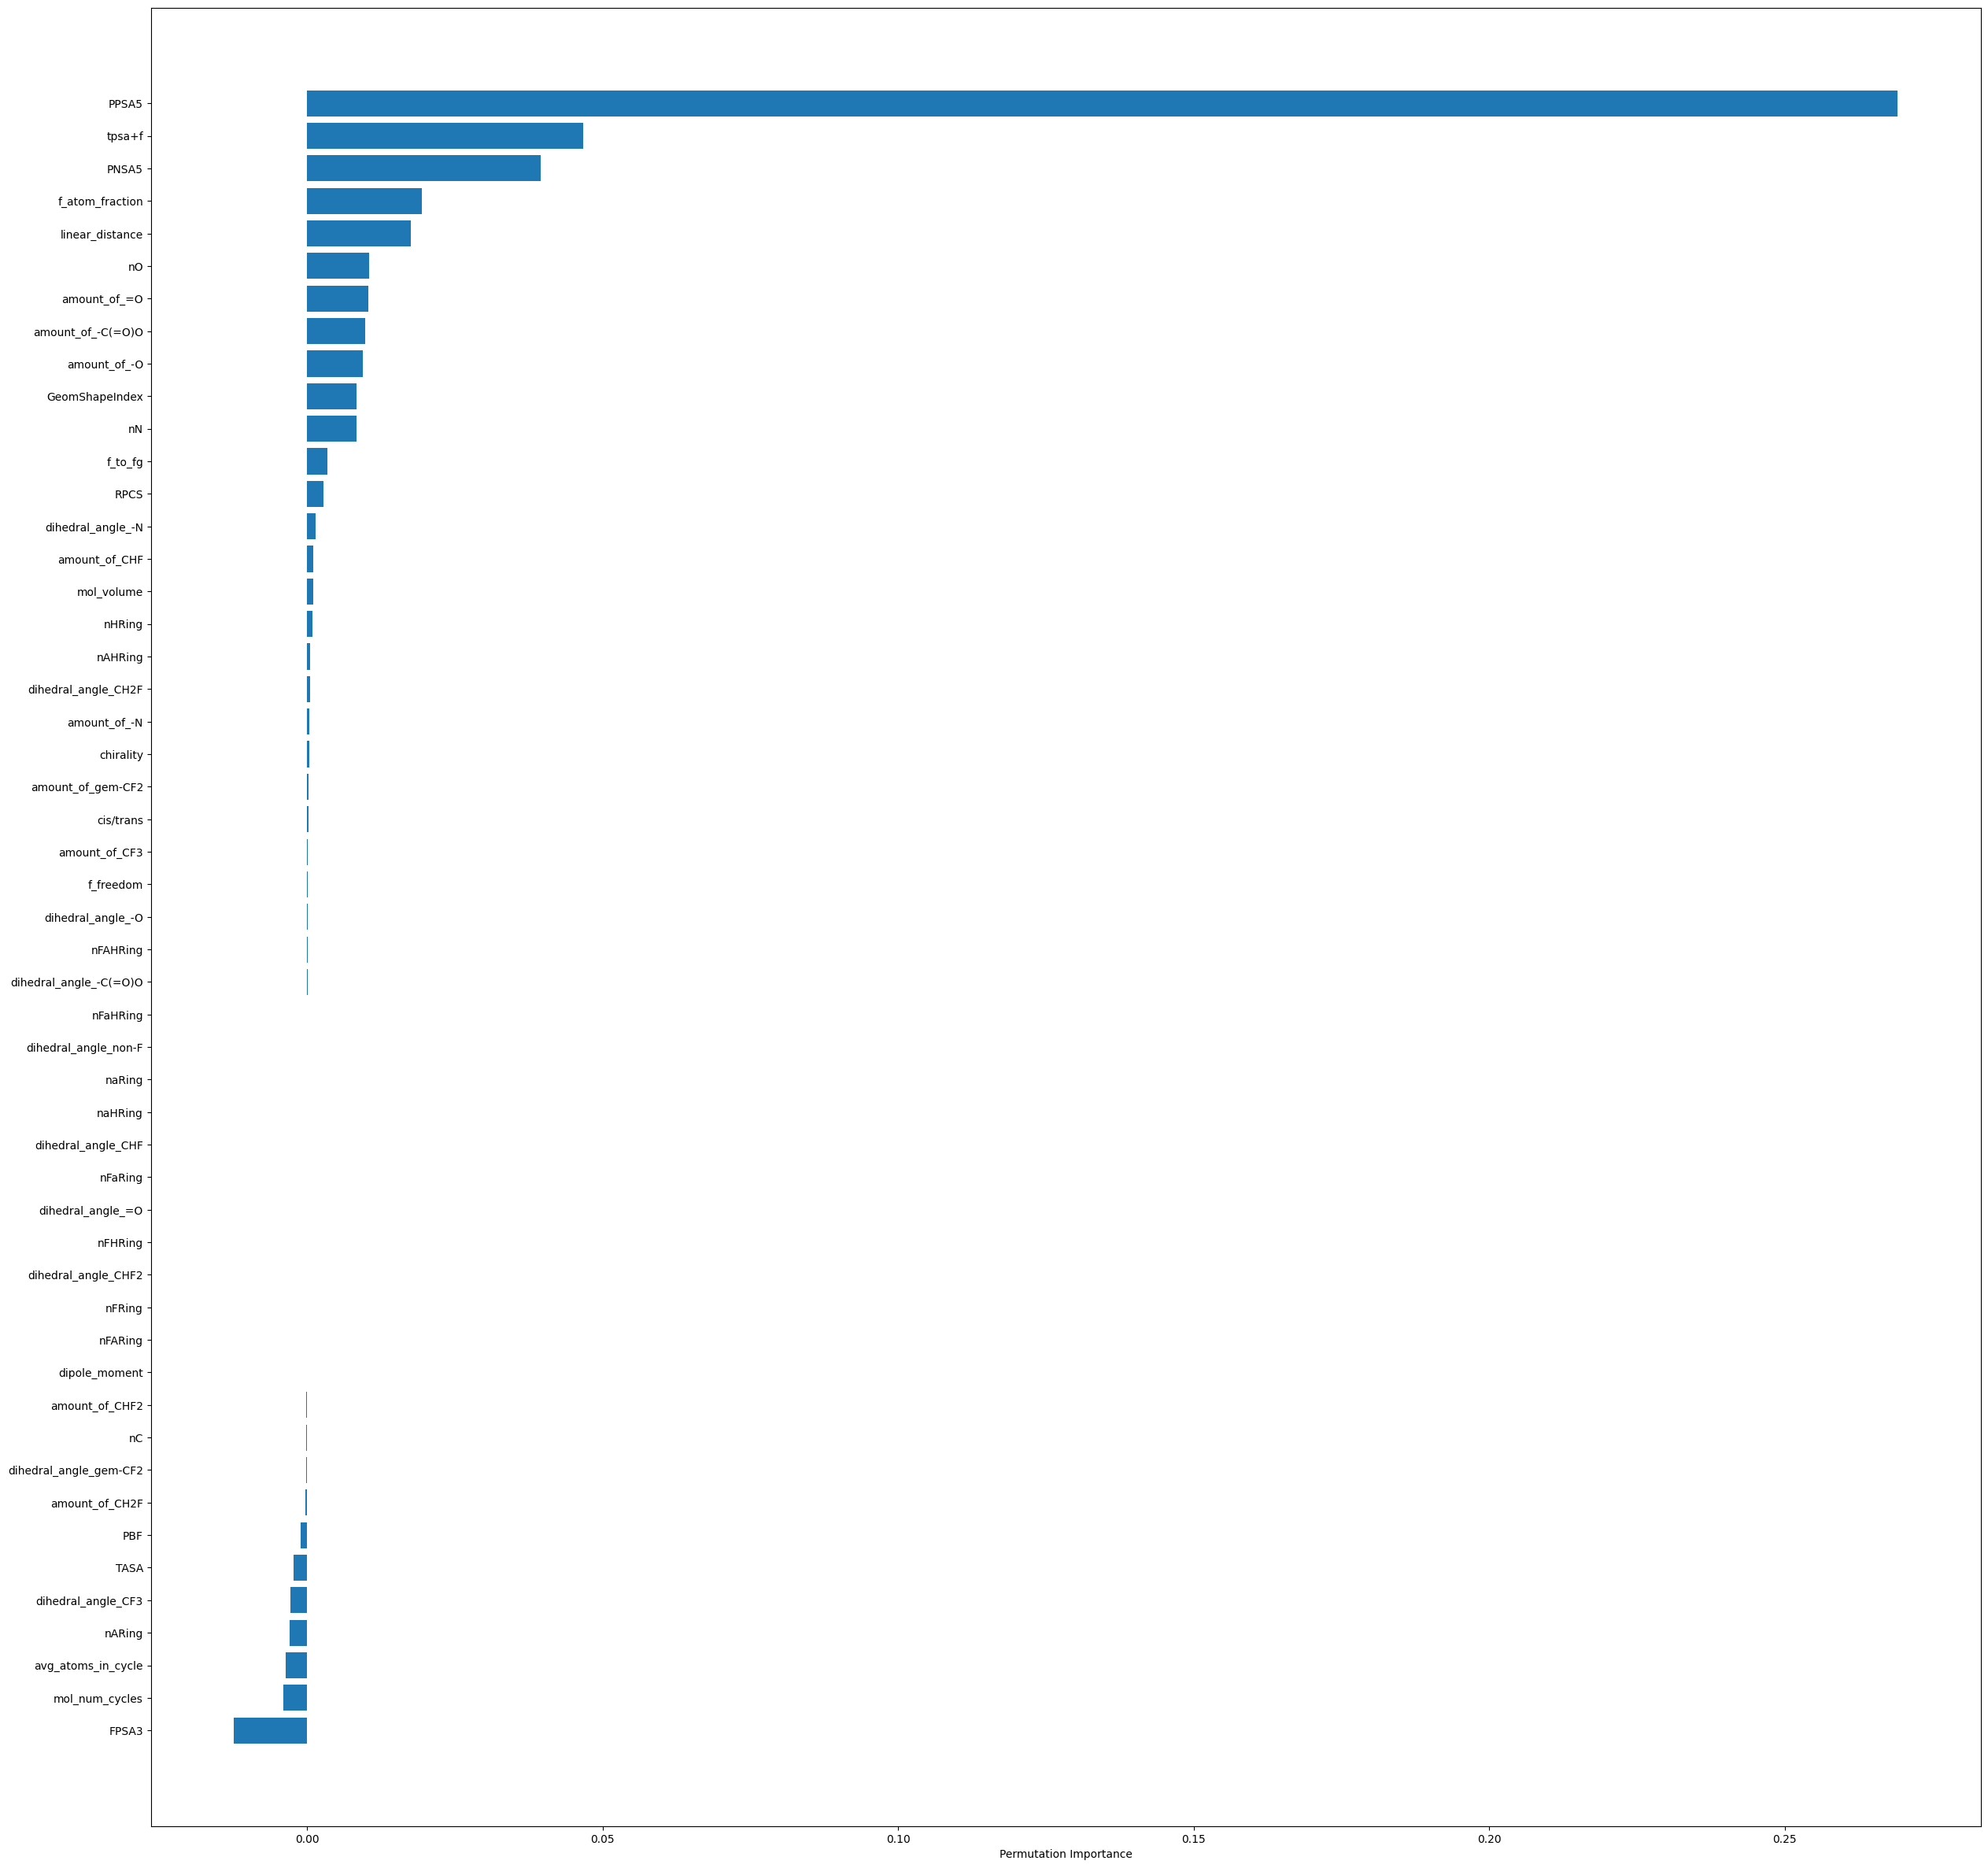

In [7]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(model, X_test, y_test)

sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(30,30))
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

**SHAP**

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


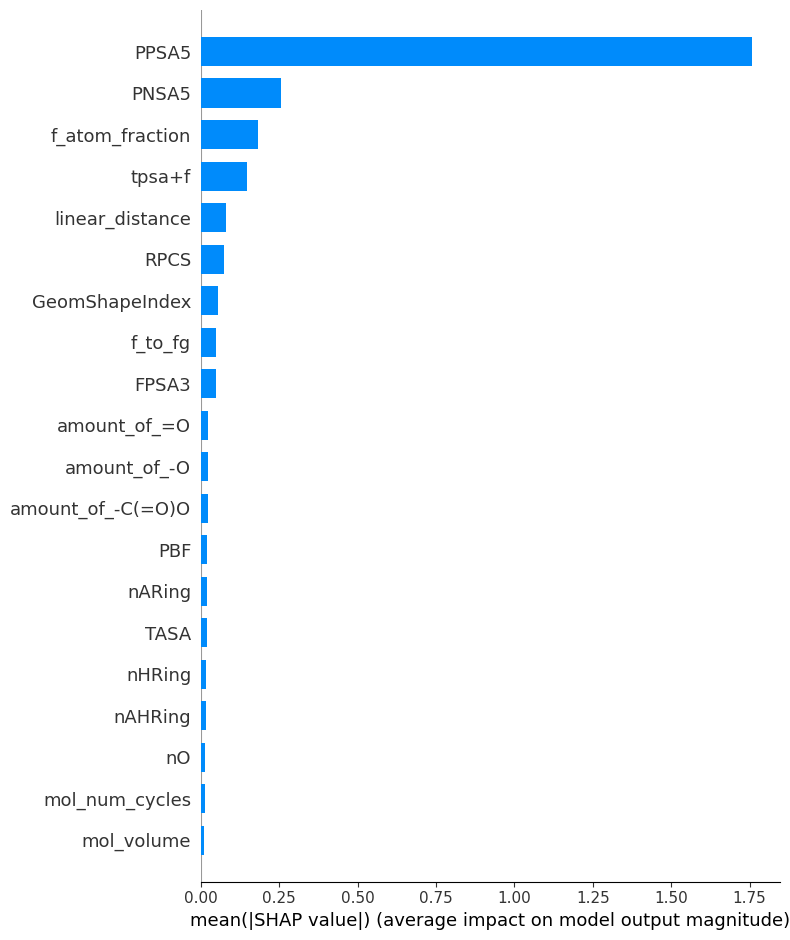

In [17]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


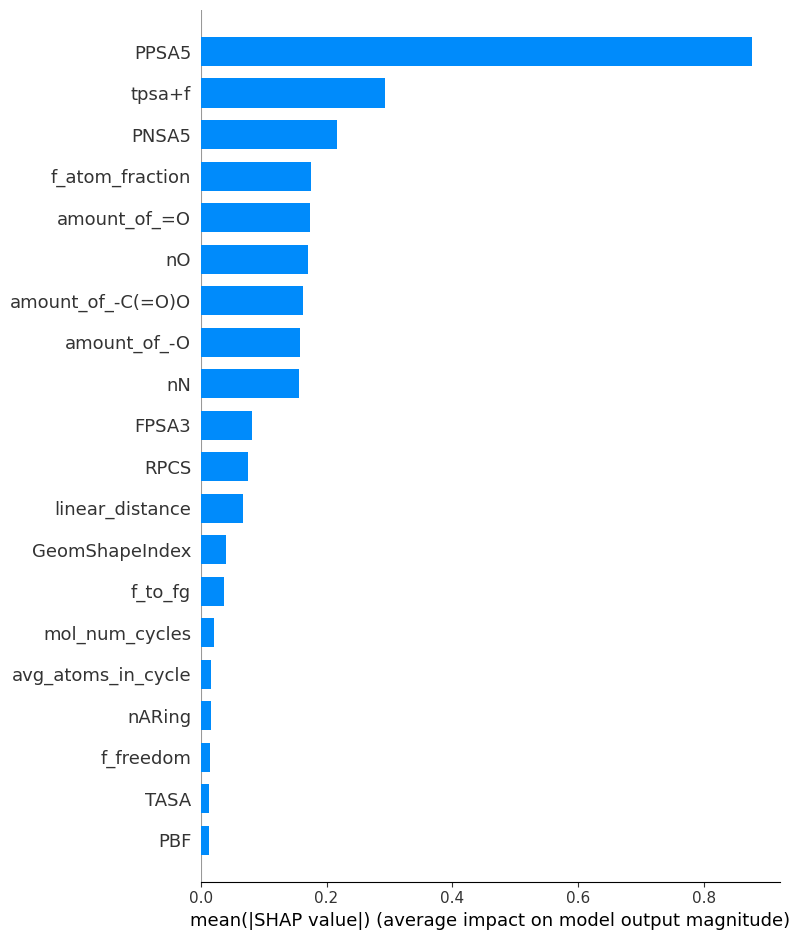

In [8]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")


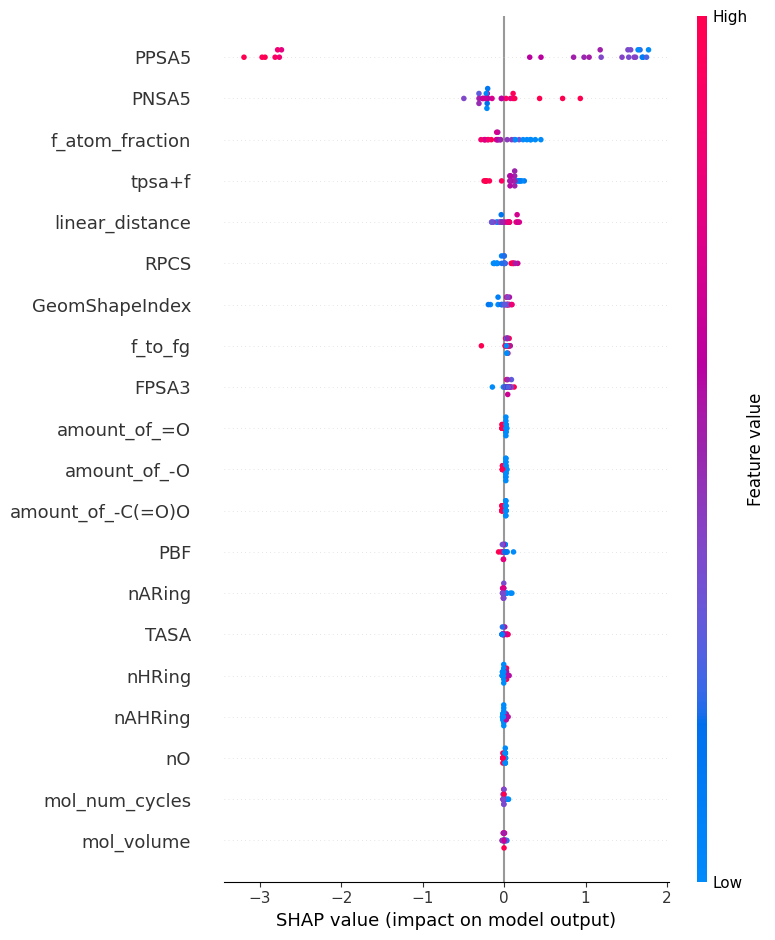

In [18]:
shap.summary_plot(shap_values, X_test)

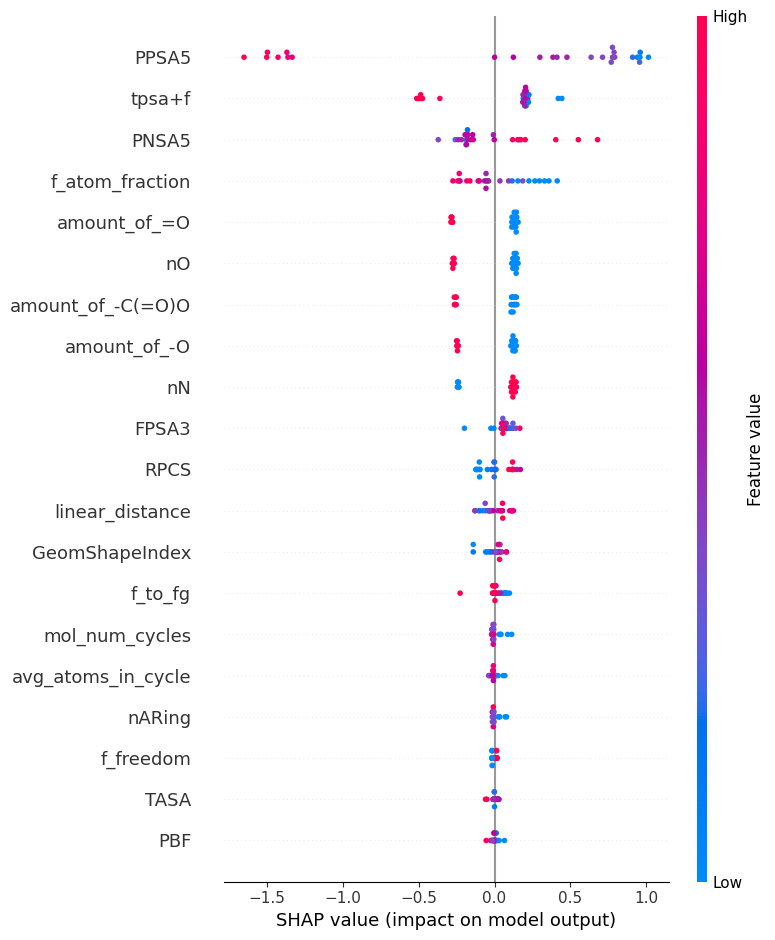

In [9]:
shap.summary_plot(shap_values, X_test)